NameError: name 'snaps' is not defined

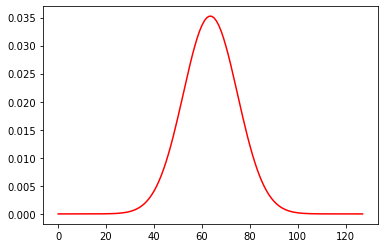

In [2]:
import numpy as np
from numpy import pi
# importing Qiskit
from qiskit import QuantumCircuit
from qiskit import ClassicalRegister, QuantumRegister
import matplotlib.pyplot as plt
def sim_sv(qc,text):
    """Get the statevecor of the output of the circuit qc"""
    #import libs
    from qiskit_textbook.tools import vector2latex
    from qiskit import Aer, execute
    from qiskit.quantum_info import Statevector
    #code
    sv_sim = Aer.get_backend('statevector_simulator')
    sv = execute (qc, sv_sim).result().get_statevector()
    #vector2latex(sv, pretext = "|"+ text + "\\rangle =")
    return sv
def qft_rotations(circuit, n):
    """Performs qft on the first n qubits in circuit (without swaps)"""
    for i in range (n):
        circuit.h(i)
        m = 1
        for j in range (i+1,n):
            m = m +1; 
            circuit.cu1(-2*pi/2**(m), i, j)
            
def swap_registers(circuit, n):
    for qubit in range(n//2):
        circuit.swap(qubit, n-qubit-1)
    return circuit
def makeQFTgate(N):
    """returns a gate of centred QFT, swaps qubits"""
    temp = QuantumCircuit (N)
    swap_registers(temp, N)
    qft_rotations(temp,N)
    #temp.x(n-1);
    QFTC = temp.to_gate()
    QFTC.name = "QFT_" + str(N) 
    return QFTC
def phase(n, phi):
    """returns the phase transformation gate for n qubits"""
    qc = QuantumCircuit(n+1);
    for i in range (n):
        qc.u1(phi/(2**(i+n-3)), n-1-i)
    for i in range (n):
        for j in range (i+1,n):
            qc.cx(n-1-j, n)
            qc.cx(n-1-i, n)
            qc.u1(phi* (2**(2-i-j)), n) #2-i-j or 4?
            qc.cx(n-1-i, n)
            qc.cx(n-1-j, n)
    phcirc = qc.to_gate()
    phcirc.name = 'phase'+str(phi)
    return phcirc
def evolve (n,phi,initial_state, stepsnumber):
    ## make the circuit
    n1 = n+1
    snaps = []
    #qubits
    for i in range (stepsnumber):
        q = QuantumRegister(n1)
        qc = QuantumCircuit(q)
        qc.barrier();
        #initialization
        magnitude = np.linalg.norm(initial_state)
        initial_state =initial_state/magnitude
        qc.initialize(initial_state, list(range(n))) 
        qc.barrier();
        #QFT
        QFT = makeQFTgate(n)
        qc.append(QFT,range(n))
        qc.barrier();
        #phase
        ph = phase (n,(i+1)*phi)
        qc.append(ph,range(n+1))
        qc.barrier();
        #inverse QFT
        QFTi = QFT.inverse()
        QFTi.name = "QFTi_" + str(n)
        qc.append(QFTi,list(range(n)))
        qc.barrier()
        #another phase for the harmonic potential
        #qc.append(ph,range(n+1))
        #qc.barrier();
        
        finalstate = sim_sv(qc,'\psi')
        prob = np.square(abs(finalstate))
        snaps.append(prob)
    #return snaps
    return qc
def action ():
    #snaps = evolve(n,phi,initial_state, stepsnumber)
    plt.plot(np.square(abs(initial_state)),'r')
    leg = ["initial"]
    for i in range (stepsnumber):
        plt.plot(snaps[i])
        leg. append ("step_"+str(i+1))
    x=plt.axis([0, 2**n-1, 0, 1.1*max(np.square(abs(initial_state)))])
    plt.legend(leg)
    return snaps
##parameters
n = 7; ## number of qubits
phi = 1*pi; ##time of evolution 
#initial_state = np.sqrt(np.exp(-(np.linspace(0,2**n-1, 2**n) - (2**n/3) +0.5)**2/(2*15**2)))+np.sqrt(np.exp(-(np.linspace(0,2**n-1, 2**n) - (2*2**n/3) +0.5)**2/(2*15**2)))
width= 2**n/8;
k=1; # k momentum; 
initial_state = (np.exp(-(np.linspace(0,2**n-1, 2**n) - (2**n/2) +0.5)**2/(2*width**2)))*(np.exp(-k*1j*(np.linspace(0,2**n-1, 2**n) - (2**n/2) +0.5)))# n Centred Gaussian

#initial_state = [0,1,1,0] # n=2 Pi function
#initial_state = [0,0,1,1,1,1,0,0] #n=3 Pi function
#initial_state = [0,0,0,0,1,1,1,1,1,1,1,1,0,0,0,0] #n=4 Pi function

##general energy state 
#w=0 #harmonic
#mom = np.zeros(2**n);
#mom[w]=1
#mom [2**n-w]=1
#initial_state= np.fft.fft(mom,2**n)
magnitude = np.linalg.norm(initial_state)
initial_state =initial_state/magnitude


stepsnumber = 1; 
snaps=action()

# try removing and putting x, swaps, inv F in place of F, and so on in the harmonic potential. 

In [3]:
qc = evolve(n,phi,initial_state, stepsnumber)

<ipython-input-2-042598369ec7>:25: DeprecationWarning: The QuantumCircuit.cu1 method is deprecated as of 0.16.0. It will be removed no earlier than 3 months after the release date. You should use the QuantumCircuit.cp method instead, which acts identically.
  circuit.cu1(-2*pi/2**(m), i, j)
<ipython-input-2-042598369ec7>:44: DeprecationWarning: The QuantumCircuit.u1 method is deprecated as of 0.16.0. It will be removed no earlier than 3 months after the release date. You should use the QuantumCircuit.p method instead, which acts identically.
  qc.u1(phi/(2**(i+n-3)), n-1-i)


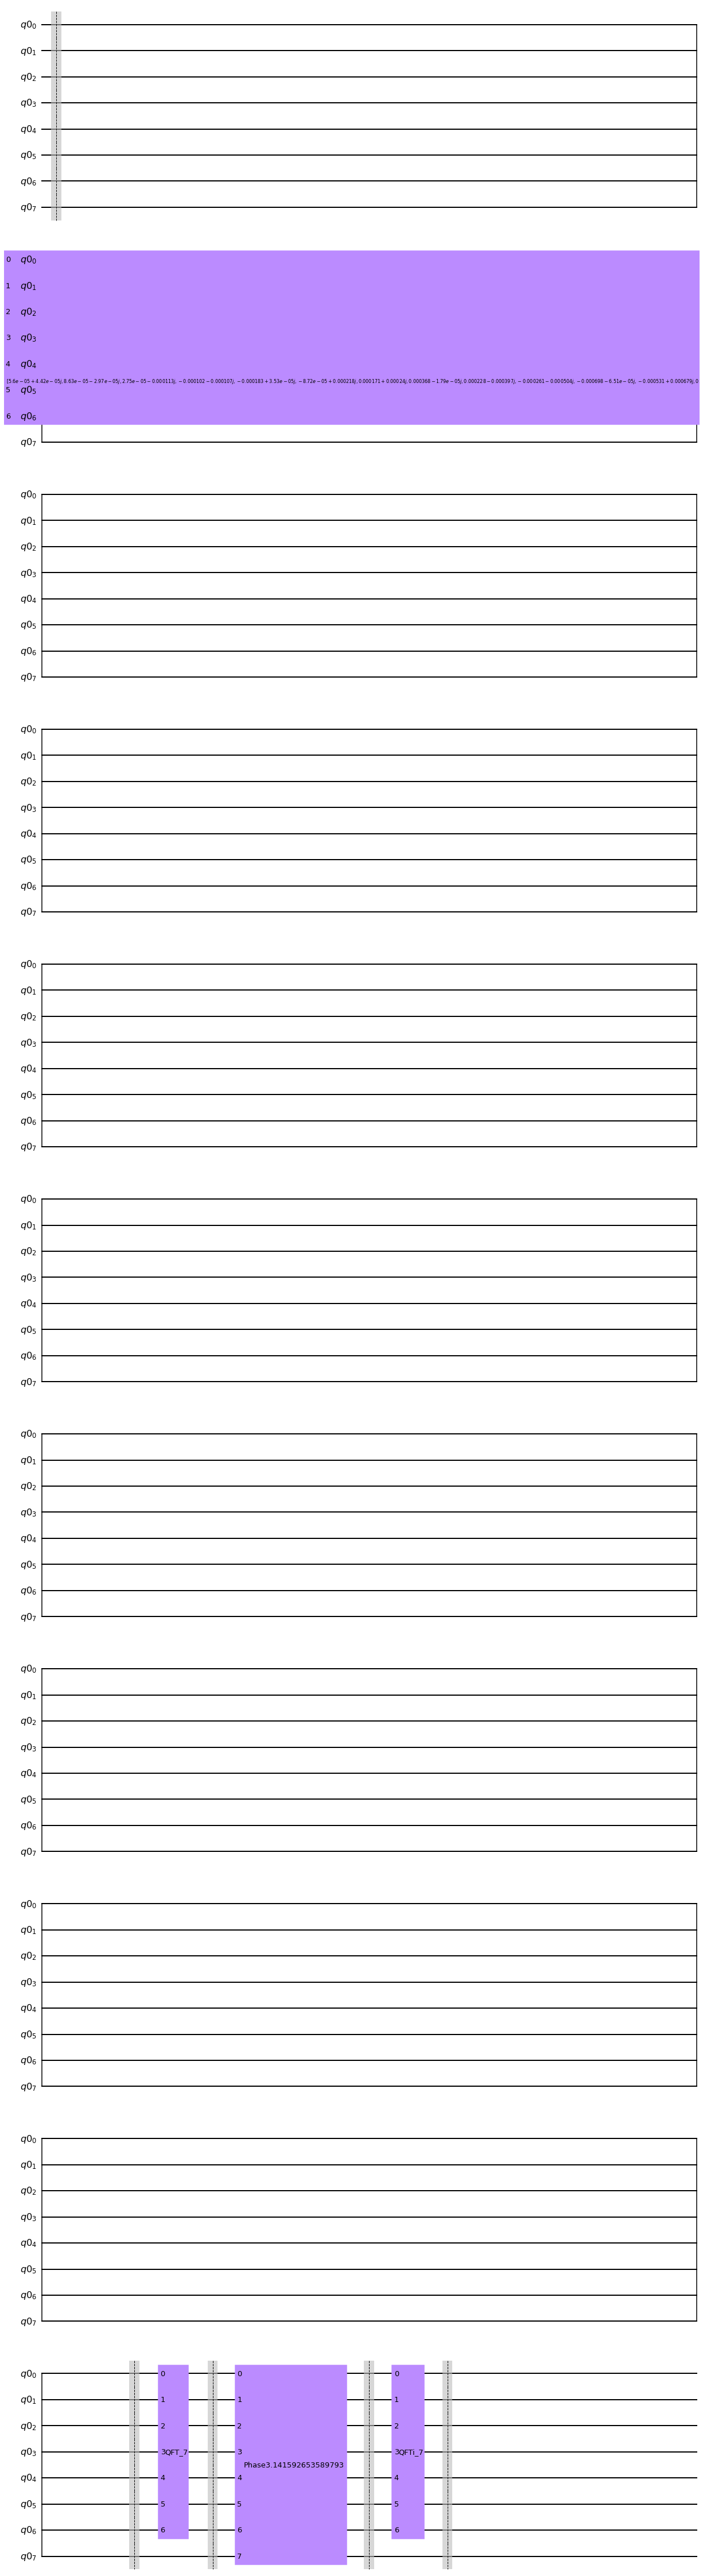

In [5]:
qc.draw('mpl')


In [6]:
qc.measure_all()

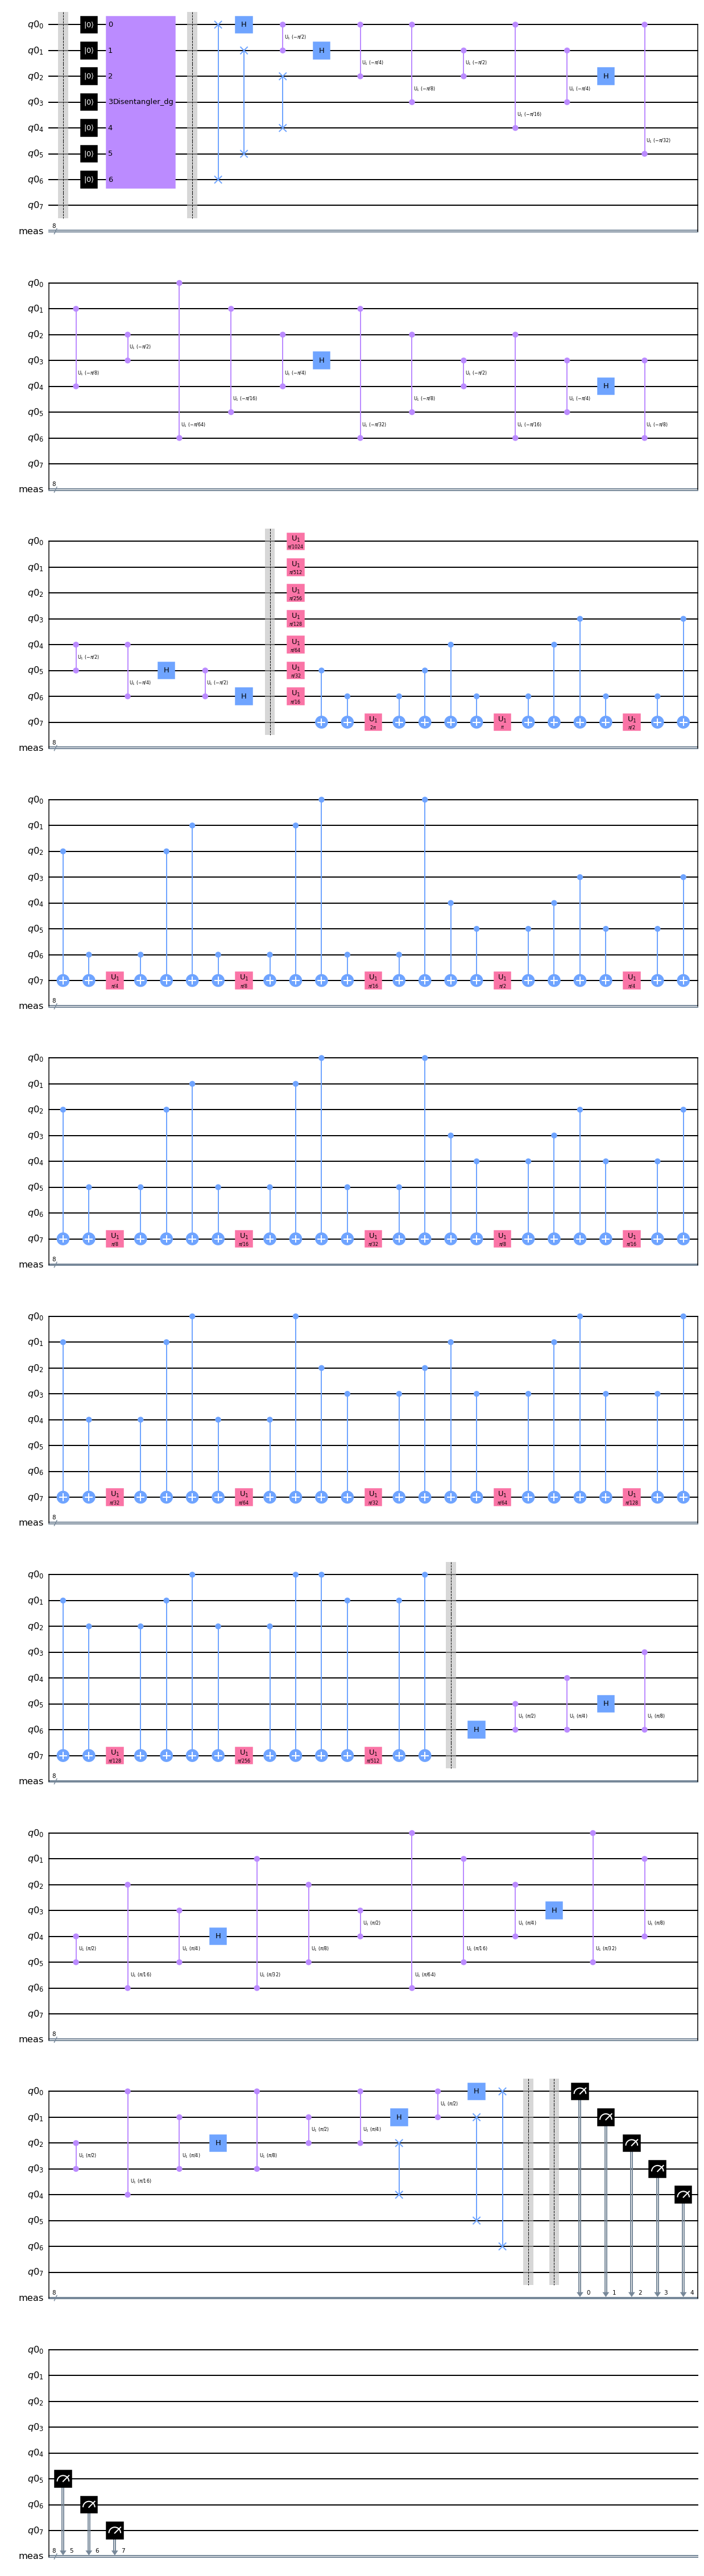

In [8]:
qc.decompose().draw('mpl')

In [35]:
def sim_real(qc):
    """simulate the circuit qc on a real device and return the prob dist"""
    from qiskit import IBMQ
    IBMQ.save_account('903ffcbecbe4edc379d77d44f37be4041be547c171a65040d2f54e4c6fdc2386b8d23b52010d86e9fd691d0e2e025d60fd1809f617eb6c13c911c139b6956f9c')
    IBMQ.load_account()
    provider = IBMQ.get_provider(hub='ibm-q')
    provider.backends()
    backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits <= 5 and
                                   x.configuration().n_qubits >= 2 and
                                   not x.configuration().simulator and x.status().operational==True))
    print("least busy backend: ", backend)
    from qiskit.tools.monitor import job_monitor

    shots = 1024
    job = execute(qc, backend=backend, shots=shots)

    job_monitor(job, interval = 2)
    results = job.result()
    answer = results.get_counts(qc)
    print(answer)
    plot_histogram(answer)
    return answer

In [36]:
sim_real(qc)

configrc.store_credentials:WARNING:2020-12-10 13:45:28,227: Credentials already present. Set overwrite=True to overwrite.
ibmqfactory.load_account:WARNING:2020-12-10 13:45:29,051: Credentials are already in use. The existing account in the session will be replaced.


least busy backend:  ibmqx2
Job Status: job has successfully run
{'0000': 169, '0001': 161, '0010': 164, '0011': 174, '0100': 21, '0101': 28, '0110': 18, '0111': 27, '1000': 62, '1001': 55, '1010': 52, '1011': 63, '1100': 9, '1101': 5, '1110': 6, '1111': 10}


{'0000': 169,
 '0001': 161,
 '0010': 164,
 '0011': 174,
 '0100': 21,
 '0101': 28,
 '0110': 18,
 '0111': 27,
 '1000': 62,
 '1001': 55,
 '1010': 52,
 '1011': 63,
 '1100': 9,
 '1101': 5,
 '1110': 6,
 '1111': 10}

In [29]:
from qiskit.providers.ibmq import least_busy

In [31]:
from qiskit import IBMQ, Aer, QuantumCircuit, ClassicalRegister, QuantumRegister, execute

In [2]:
#import visualization
from qiskit.visualization import plot_histogram

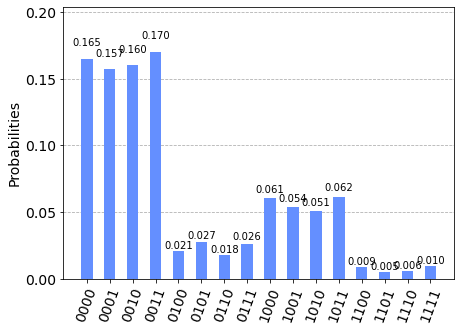

In [38]:
 plot_histogram({'0000': 169,
 '0001': 161,
 '0010': 164,
 '0011': 174,
 '0100': 21,
 '0101': 28,
 '0110': 18,
 '0111': 27,
 '1000': 62,
 '1001': 55,
 '1010': 52,
 '1011': 63,
 '1100': 9,
 '1101': 5,
 '1110': 6,
 '1111': 10})

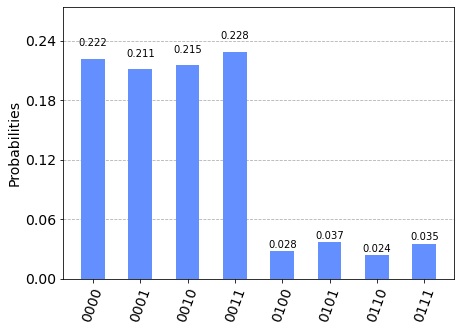

In [4]:
 plot_histogram({'0000': 169,
 '0001': 161,
 '0010': 164,
 '0011': 174,
 '0100': 21,
 '0101': 28,
 '0110': 18,
 '0111': 27})